In [5]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import jax.numpy as jnp
import os
from perch.perch_ph import PH
from perch.perch_structures import Structures
import matplotlib.pyplot as plt

In [6]:
rname = 'phangs'
ddir = '/Users/toneill/Perch/phangs/'
perchdir = f'/Users/toneill/Perch/output/'
odir = f'{perchdir}{rname}/'

if not os.path.isdir(perchdir):
    os.mkdir(perchdir)
if not os.path.isdir(odir):
    os.mkdir(odir)
os.chdir(odir)

In [7]:
img_hdu = fits.open(ddir+'ngc0628_miri_f770w_anchored.fits')

wcs_img = WCS(img_hdu[0].header)#[375:875,375:875,375:875]
img = img_hdu[0].data#[375:875,375:875,375:875]

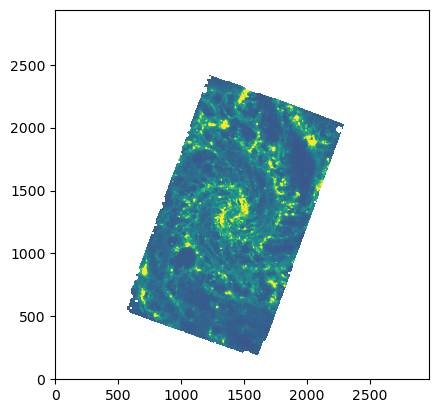

In [8]:
plt.imshow(img,origin='lower',vmax=10,cmap='Greys_r')

## STEP 1: compute persistent homology candidates

In [10]:
hom = PH.compute_hom(img,verbose=True,wcs=wcs_img,engine='C')
#hom.export_generators(f'{rname}.txt',odir=odir)
#hom = PH.load_from(f'{rname}.txt',odir=odir,data=img)

Computing PH... 

\n PH Computation Complete! 
 1.2s elapsed


## STEP 2: filter candidates by some threshold

In [49]:
dim_use = 1
hi = hom.filter(dimension=dim_use)
all_life = hi.persistence

all_thresh = np.nanquantile(all_life,0.95)
all_thresh

0.3498241901397702

Text(0, 0.5, 'Lifetime')

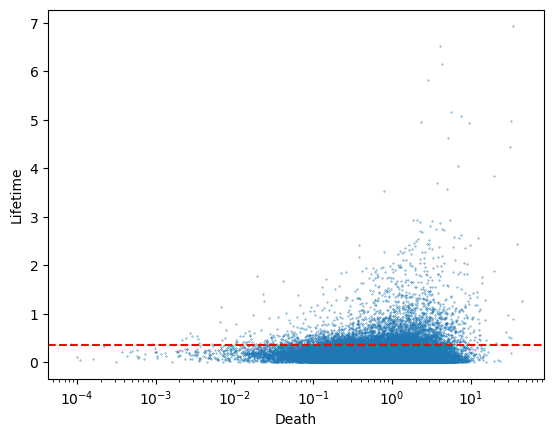

In [50]:
plt.figure()
plt.scatter(hi.death, hi.persistence,s=0.1)
plt.gca().set_xscale('log')
plt.gca().set_yscale('linear')
plt.axhline(y=all_thresh,c='r',ls='--')
plt.xlabel('Death')
plt.ylabel('Lifetime')

In [51]:
strucs = hom.filter(min_life=all_thresh, dimension=1)
strucs.n_struc

5471

## STEP 3: segment original image

In [52]:
img_jnp = jnp.array(img)
strucs.compute_segment_hierarchy(img_jnp)
#strucs.compute_segment(img_jnp)
#strucs.compute_hierarchy(clobber=True)
#strucs.export_struc_map(fname=fname, odir=odir)

100%|██████████| 5471/5471 [02:24<00:00, 37.79structures/s]


Text(0.5, 1.0, 'Perch structures (by ID)')

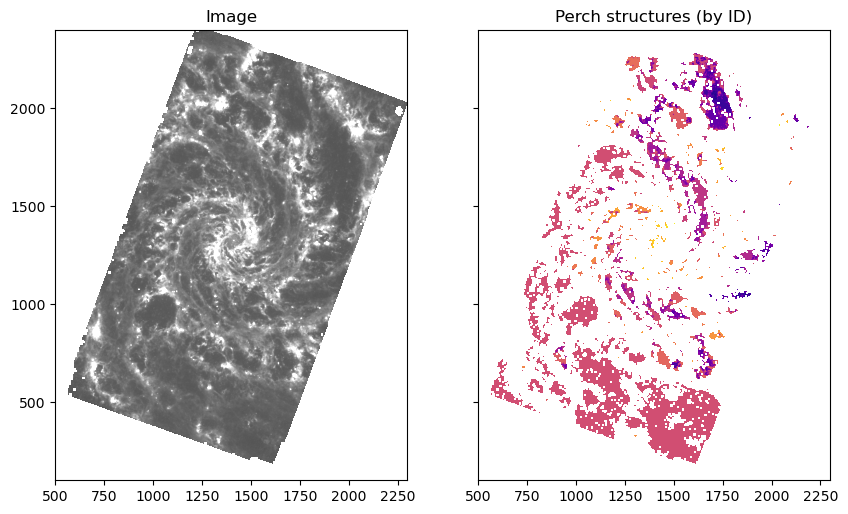

In [53]:
fig, [ax1,ax2] = plt.subplots(1,2,figsize=(10,6),sharex=True,sharey=True)
plt.axes(ax1)
plt.imshow(img,cmap='Greys_r',origin='lower',vmax=10)
plt.title('Image')
plt.xlim(500,2300)
plt.ylim(100,2400)

plt.axes(ax2)
plt.imshow(strucs.struc_map,cmap='plasma',alpha=1,origin='lower')
plt.title('Perch structures (by ID)')

Text(0.5, 0, 'Log $R_{eff}$ [pix]')

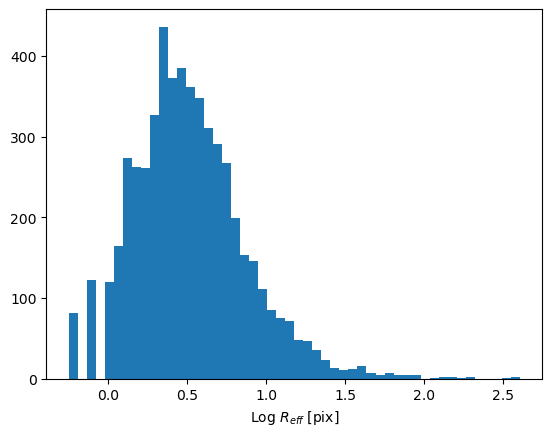

In [54]:
plt.figure()
plt.hist(np.log10(strucs.equiv_radius),bins=50)
plt.xlabel('Log $R_{eff}$ [pix]')